```
---
title: Patsy + Feature Scaling
duration: "~1:5"
creator:
    name: David Yerrington
    city: SF
---
```
<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

# Patsy + Feature Scaling

Week 3 | Codealong 3.2

---

To round out our workflow in what we sometimes refer to as the **preprocessing pipeline**, we will be working with normalizing features within our dataset(s), and converting our data to design matrices with **Patsy**, before using models with a linear component (ie: linear regression).






## Why Feature Scaling

The majority of machine learning methods will perform better when our variables are on the same scale.  Some methods will optimize for larger errors in spaces that have a bigger range in the case where some features are weighted by errors.  Other cases include methods that rely on euclidean distances (ie: KNN, K-Means), or linearly sperable points, which means that scaling can have a desirable impact.  The most obvious cases were this makes sense is when you have features that are drastically different _and_ we want them within a bound interval.

### Normalizing or standarding prevents features from dominating each other in machine learning.  The larger numbers are going to be larger in weight.

<br>

Consider the example we've talked about a times when we are predicting the value of real-estate properties, and we have a variable "square feet" within 1-10,000, and "number of bathrooms" between 1-3.



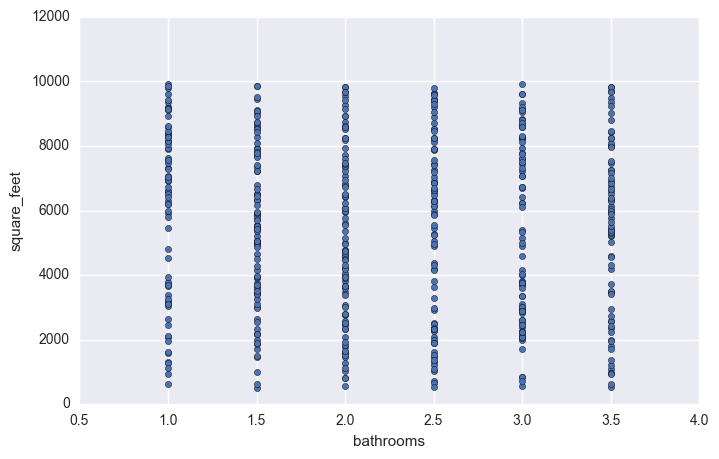

In [20]:
import seaborn as sns, pandas as pd
import numpy as np

%matplotlib inline

# Creating some artificial data
df = pd.DataFrame()
df['square_feet'] = np.random.randint(500, 10000, 500)
df['bathrooms'] = np.random.choice(np.arange(1, 4, 0.5), size=500)

# Plot it!
df.plot(kind="scatter", x="bathrooms", y="square_feet", figsize=(8,5))

There are two approaches to scaling.

**Min-max scaling** (sometimes called _normalization_), which typically means rescaling features from 0 to 1.  There are a lot of different methods for transforming your data to scale.  The methods in `sklearn.preprocessing` are extremely fast compared to doing this calculation by hand and are very well tested.

![](https://snag.gy/DEwF4T.jpg)


In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


normalized = pd.DataFrame(scaled_data, columns=["norm_square_feet", "norm_bathrooms"])
normalized.head(10)
# normalized.describe().T
# # normalized.head()

,norm_square_feet,norm_bathrooms
0,0.662277,1.0
1,0.264125,0.2
2,0.597918,0.6
3,0.195093,1.0
4,0.505416,0.6
5,0.720901,0.0
6,0.135302,1.0
7,0.218458,1.0
8,0.788339,0.8
9,0.648046,1.0


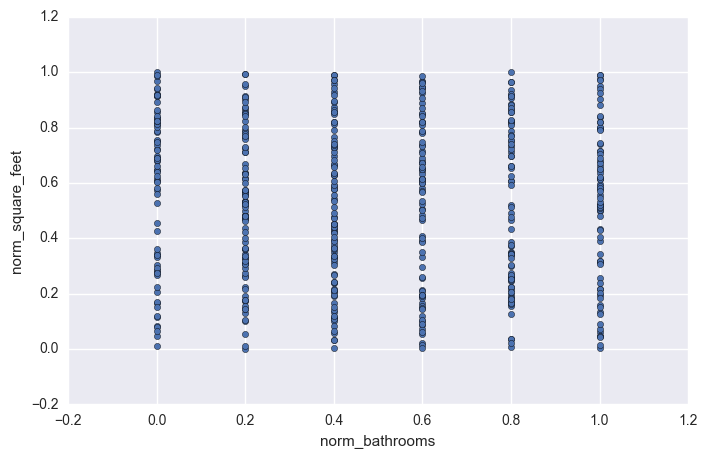

In [22]:
normalized.plot(kind="scatter", x="norm_bathrooms", y="norm_square_feet", figsize=(8,5))

Alternatively, we may want to use **standardization** to scale our variables to 0 for the mean, with a standard deviantion of 1, in effect creating a normal distribution.  This actually makes it easier for machine learning methods to learn variable weights (ie: stochastic gradient descent, [Newton-CG](https://en.wikipedia.org/wiki/Nonlinear_conjugate_gradient_method), or OLS regression!)

![](https://snag.gy/VNbp4H.jpg)

> _In this form, the mean and standard deviation is represented for each variable that is being standardized._

Where **min-max normalization** is sensitive to outliers, **standardization** is not as sensitive to outliers but still retains some of those characteristics because the range isn't limited to a set of fixed values (0-1).


In [23]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

standardized = pd.DataFrame(scaled_data, columns=["stand_square_feet", "stand_bathrooms"])
standardized.describe().T

,count,mean,std,min,25%,50%,75%,max
stand_square_feet,500.0,-1.643130e-17,1.001002,-1.853335,-0.880097,0.071498,0.856449,1.690707
stand_bathrooms,500.0,-2.842171e-16,1.001002,-1.503279,-0.897118,-0.290957,0.921364,1.527525


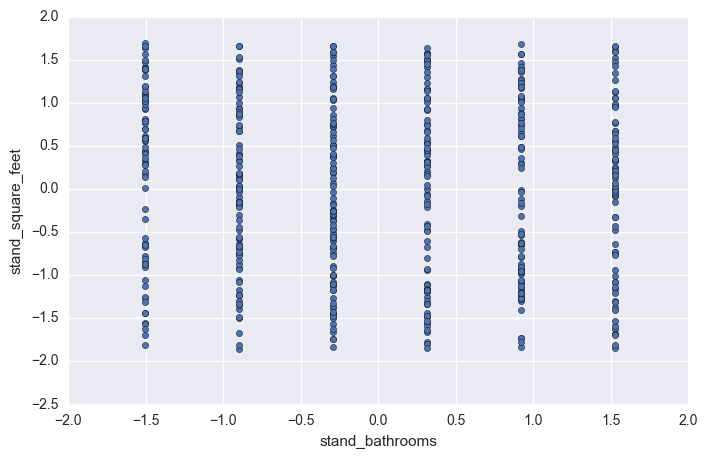

In [24]:
standardized.plot(kind="scatter", x="stand_bathrooms", y="stand_square_feet", figsize=(8,5))

### Normalized vs Standardized Compared

In [25]:
# Consolidate some data
df['norm_bathrooms']    =  normalized['norm_bathrooms']
df['norm_square_feet']  =  normalized['norm_square_feet']

df['stand_bathrooms']   =  standardized['stand_bathrooms']
df['stand_square_feet'] =  standardized['stand_square_feet']

print "Bathrooms"
# df[['bathrooms', 'norm_bathrooms', 'stand_bathrooms']].head()

Bathrooms


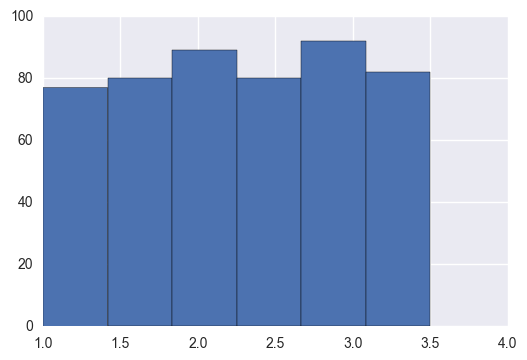

In [17]:
df['bathrooms'].hist(bins=6)

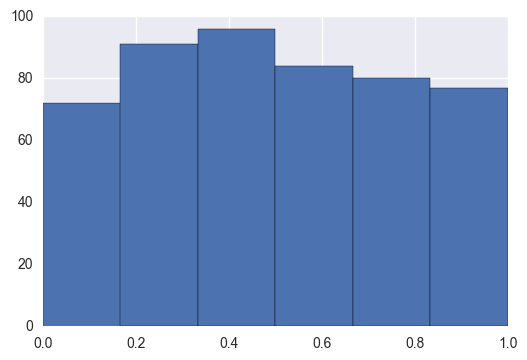

In [26]:
df['norm_bathrooms'].hist(bins=6)

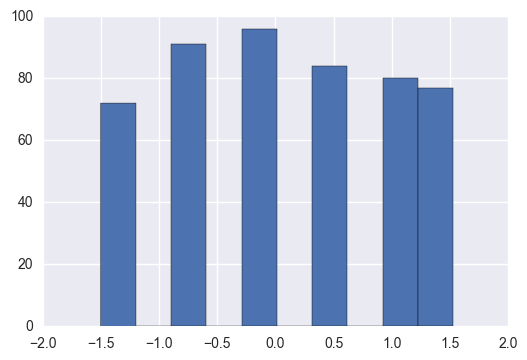

In [27]:


df['stand_bathrooms'].hist()

Square Feet


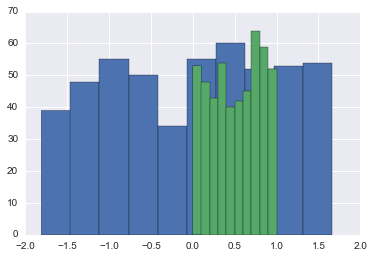

In [137]:
print "Square Feet"

# df['square_feet'].hist()
df['stand_square_feet'].hist()
df['norm_square_feet'].hist()
# df[['square_feet', 'norm_square_feet', 'stand_square_feet']].head(10)

## Some Guidelines

- Standardize when there is a huge variance in values.
- Standardize when a single feature can have both a positive and negative effect.
- **Consider** normalizing anything that will be used with Euclidean distance.

### General Questions
- Is the algorithm heavily influenced by different scales of different features?
- Do your features share the comparable scales already?
- Does your algorithm already normalize your data? _(Linear Discriminant Analysis and Naive Bayes)_
  - Does it care? _(ie: decision trees / CART models)_
  
#### Don't forget to keep your original UNSCALED variables if you care about referencing the original values.  You can omit them from your models.

## Feature Scaling

1. Fitting your model will be faster on larger datasets.
1. Prevents getting stuck in local optima.
1. When scales of variables are vastly different.
1. When we want small valued features to contribute more equally.

# Patsy!

Yes we learened a lot this week.  Yes Patsy may seem like yet another unecessary step but we it's actually very useful.  We will explore this utility that gives us the power of design matrices in a live coding example.

>_patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S._

> Check out the docs:  https://patsy.readthedocs.io/en/latest/overview.html

Patsy is not just useful for linear models, but anytime you may want to encode or modify your dataset in preprocessing step before modeling.

### Load Patsy

In [28]:
import patsy

### Create Some Fake Data
With 2-3 continious variables, and one categorical.

In [29]:
df = pd.DataFrame()

df['ship_type']  =  np.random.choice(["romulan", "human", "klingon", "borg", "red_shirt", "ovid"], size=500)
df['ship_value'] =  np.random.randint(200000, 10000000, size=500)
df['ship_speed'] =  np.random.randint(10, 60, size=500)
df['baths']      =  np.random.choice(np.arange(1, 4, 0.5), size=500)

In [140]:
# df.head()

y = df['baths']
X = df[['ship_type', 'ship_value', 'ship_speed']]

,ship_type,ship_value,ship_speed,baths
0,red_shirt,5561330,19,3.0
1,red_shirt,3141237,16,1.0
2,human,8681920,19,3.5
3,human,3897025,53,1.5
4,borg,2670258,15,3.0


### Let's look at the design matrix
Using a simple formula.  

Read more about how to use formulas here:  http://patsy.readthedocs.io/en/latest/formulas.html

In [32]:
formula  =  "baths ~ ship_value + ship_speed-1"
y, X     =  patsy.dmatrices(formula, data=df, return_type="dataframe")


In [33]:
X

,ship_value,ship_speed
0,3337501.0,50.0
1,6679055.0,50.0
2,4459889.0,37.0
3,5346520.0,22.0
4,1714783.0,15.0
5,2754829.0,16.0
6,9753847.0,14.0
7,8072384.0,48.0
8,7044015.0,32.0
9,7796120.0,39.0


### Load up a linear model
Demonstrate the power of the formula and how to quickly switch out our forumula, without having to reslice our data.

In [180]:
from sklearn.linear_model import LinearRegression

scores = []

formulas  =  {
    "baths_prediction_1": "baths ~ ship_value + ship_speed",
    "baths_prediction_2": "baths ~ ship_value",
    "baths_prediction_3": "baths ~ ship_type"
}

for formula_name, formula in formulas.items():

    y, X     =  patsy.dmatrices(formula, data=df, return_type="dataframe")

    lm = LinearRegression()
    model = lm.fit(X, y)
    score = model.score(X, y)
    
    scores.append({
        "formula_name":  formula_name, 
        "formula":       formula,
        "R^2":           score
    })
    
pd.DataFrame(scores)


,R^2,formula,formula_name
0,0.003779,baths ~ ship_value + ship_speed,baths_prediction_1
1,0.021820,baths ~ ship_type,baths_prediction_3
2,0.003070,baths ~ ship_value,baths_prediction_2


### You will have questions.

This is a very standard implementation of Patsy with feature scaling.

In [190]:
from sklearn.preprocessing import StandardScaler

# Scale our data first
scaler      =  StandardScaler()
columns     =  ['ship_value', 'ship_speed']
df[columns] =  scaler.fit_transform(df[columns])

formula  =  "baths ~ ship_value + ship_speed"
y, X     =  patsy.dmatrices(formula, data=df, return_type="dataframe")

lm = LinearRegression()
model = lm.fit(X, y)
score = model.score(X, y)

print "R^2: ", score


R^2:  0.0037785367171


## Independent Practice

Create a class with the following methods:

- An init method
- A method called "fit" that sets a class attribute called "vector" (single np.array)
- A method called "transform" that processes the class variable "vector", returning a standardized vector

## Bonus Practice
- Create a method that will standardize a vector or a matrix
- Create a method that will normalize a vector or a matrix
- Update your init method to take a paramter that set either "standardize" or "normalize" when the "transform" method is called.
- Additionally create a method that will return a MinMax scaled set of vectors of a matrix

### Bonus Bonus
- Have your class methods handle either vector or matrix as input

_Think about setting a class variable called "data" and checking wether it's a vector or a matrix depending on shape._